In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
from matplotlib.lines import Line2D
from scipy.stats import beta as beta_dist
import pandas as pd
from tabulate import tabulate
import warnings
import seaborn as sns
import os.path as osp
import os

In [3]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
import matplotlib
matplotlib.style.use('classic')

/tmp/ipykernel_3919853/1290025429.py:2: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('pdf', 'svg')


In [4]:
os.chdir(os.path.expanduser("/home/rr568/Fair_Ranking_under_Disparate_Uncertainty"))

In [5]:
%load_ext autoreload
%autoreload 2
from rankingFairness.src.experiment import simpleOffline
from rankingFairness.src.utils import set_seed, plotDrichletDist, plotBetaDist
from rankingFairness.src.rankings import PRP_Ranker, EO_RankerII, TS_RankerII, DP_Ranker, DP_RankerII, Uniform_Ranker, EO_Ranker
from rankingFairness.src.distributions import Bernoulli, Beta, BetaBernoulli, Multinomial, DrichletMultinomial, Drichlet

In [6]:
SEED=42
set_seed(SEED)
save_path='/share/thorsten/rr568/CostOptimal_FairRankings/plots'

In [7]:
def plot_relevance_probs(probs_a, probs_b, loc='lower right', extra=False, savefig=None):
    fig, ax =plt.subplots(figsize=(5,5))
    if extra:
        ax.scatter(np.arange(1,len(probs_a)+1), probs_a, s=80, c='teal', alpha=0.8, label='Majority Group')
        ax.scatter(np.arange(1, len(probs_b)+1), probs_b, s=80, c='lightpink', alpha=0.8, label='Minority Group')
    else:
        ax.scatter(np.arange(1,len(probs_a)+1), probs_a, s=80, c='teal',alpha=0.8)
        ax.scatter(np.arange(1, len(probs_b)+1), probs_b, s=80, c='lightpink', alpha=0.8)
    relevance_handle = ax.plot([], [], ' ', label=r'$\bf{n_A=}$'+f"{sum(probs_a):.2f},"+ r'$\bf{n_B=}$'+f"{sum(probs_b):.2f}")
    size_handle = ax.plot([], [], ' ', label=r'$\bf{\vert A \vert=}$' + f"{len(probs_a)}," +r'$\bf{\vert B \vert=}$'+ f"{len(probs_b)}")
    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles=handles, fontsize=15)

    ax.set_xlabel('Candidates', fontsize=15)
    ax.set_xticks([])
    ax.set_ylabel(r'$\mathbb{P}(r_i|\mathcal{D})$', fontsize=20)
    ax.tick_params(axis='y', labelsize=10)
    ax.tick_params(axis='x', labelsize=10)
    ax.legend( loc=loc,markerscale=1., scatterpoints=1, fontsize=15, fancybox=True, framealpha=0.5)
    plt.grid()
    plt.tight_layout()
    if savefig is not None:
        plt.savefig(f"{osp.join('/share/thorsten/rr568/CostOptimal_FairRankings/plots/relevances',str(savefig))}")
    plt.show()
    plt.close()

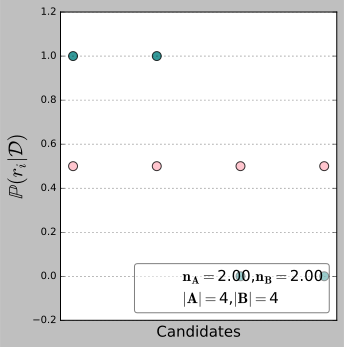

In [11]:
A_true=[1,1,0,0]
B_true=[0.5]*4
plot_relevance_probs(A_true, B_true)

100%|███████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 69760.89it/s]


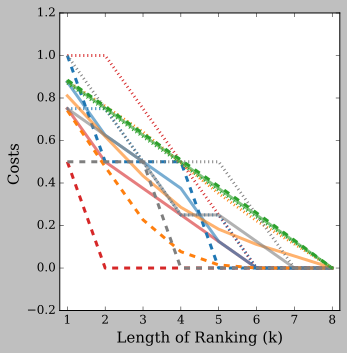

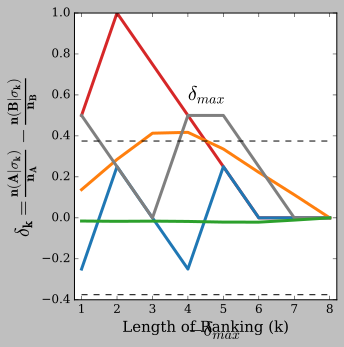

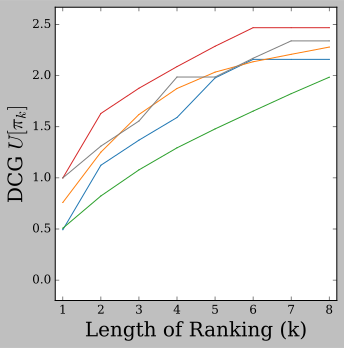

In [27]:
A_true=[0,1,0,1]
B_true=[0.5]*4
A_dist = [Bernoulli(p) for p in A_true]
B_dist = [Bernoulli(p) for p in B_true]
exp = simpleOffline(num_groups=2, start_minority_idx=len(A_true), num_docs=len(A_true)+len(B_true), 
                    predfined_ls=[A_dist, B_dist], distType=BetaBernoulli, switch_start=False)
exp.experiment(rankingAlgos=[PRP_Ranker, EO_RankerII, TS_RankerII, DP_Ranker, Uniform_Ranker], simulations=1000)

In [24]:
# A_true_theta = np.random.power(1,size=60) # true theta*
# B_true_theta = np.random.power(1,size=60)
A_true_theta = np.random.uniform(0,1,size=60) # true theta*
B_true_theta = np.random.uniform(0,1,size=30)

def getPosterior(prior, A_true, B_true, majority_samples=200, minority_samples=2):
    posterior_A = [Beta(alpha=prior[0], beta=prior[1]) for _ in np.arange(len(A_true))]
    posterior_B = [Beta(alpha=prior[0], beta=prior[1]) for _ in np.arange(len(B_true))]
    
    for i,p in enumerate(A_true):
        relevances = Bernoulli(p).sample(majority_samples)
        success = np.sum(relevances)
        failures = len(relevances)-success
        posterior_A[i].update(success, failures)
        
    for i,p in enumerate(B_true):
        relevances = Bernoulli(p).sample(minority_samples)
        success = np.sum(relevances) 
        failures = len(relevances)-success
        posterior_B[i].update(success, failures)
    
    return posterior_A, posterior_B

posterior_A, posterior_B = getPosterior(prior=(1,1), A_true=A_true_theta, B_true=B_true_theta,
                                        majority_samples=100, minority_samples=5)

100%|███████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 64085.07it/s]


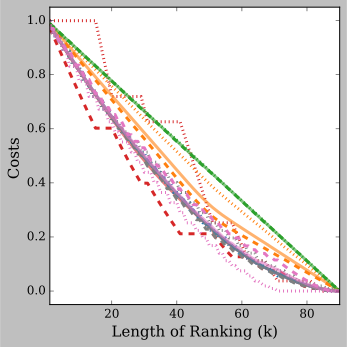

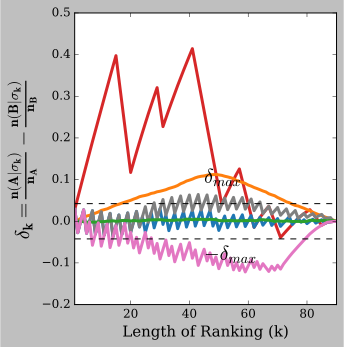

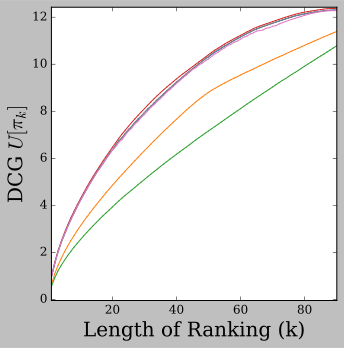

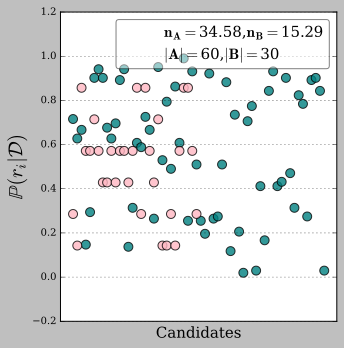

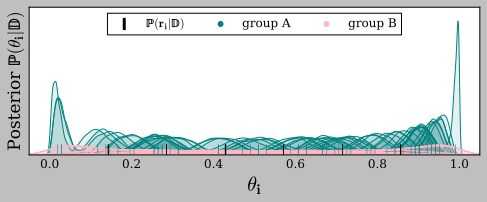

In [26]:
A_theta = [theta.getMean() for theta in posterior_A] # p(r_i|D)
B_theta = [theta.getMean() for theta in posterior_B]
    
A_dist = [Bernoulli(p) for p in A_theta]
B_dist = [Bernoulli(p) for p in B_theta]

merit_A = [Bernoulli(p).sample(1) for p in A_true_theta]
merit_B = [Bernoulli(p).sample(1) for p in B_true_theta]

merits = np.vstack((merit_A, merit_B))
assert merits.shape[0]==len(A_true_theta)+len(B_true_theta), f"{merits.shape}"
exp = simpleOffline(num_groups=2, start_minority_idx=len(A_dist), num_docs=len(A_dist)+len(B_dist), 
      predfined_ls=[A_dist, B_dist], distType=BetaBernoulli, saveFig=osp.join(save_path, 'bayesian', 'powerlaw'),
        merits=merits, offset=0.05, switch_start=False)
exp.experiment(rankingAlgos=[PRP_Ranker, EO_RankerII, TS_RankerII, DP_Ranker, Uniform_Ranker, DP_RankerII], simulations=1000)
plot_relevance_probs(A_theta, B_theta, loc='upper right', savefig='powerlaw_bayesian_rel.pdf')
alphas_majority = [(p.alpha, p.beta) for p in posterior_A]
alphas_minority = [(p.alpha, p.beta) for p in posterior_B]
plotBetaDist(alphas_majority=alphas_majority, 
    alphas_minority=alphas_minority, size=1000, loc='upper center', offset=0.05, saveFig='powerlaw_bayesian_posterior.pdf')

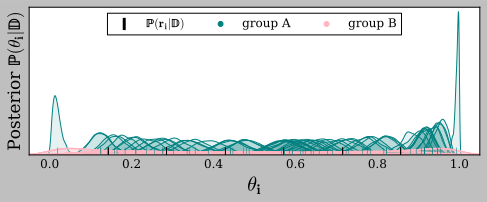

In [23]:
plotBetaDist(alphas_majority=alphas_majority, 
    alphas_minority=alphas_minority, size=1000, loc='upper center', offset=0.05, saveFig='powerlaw_bayesian_posterior.pdf')